## Implementation of Random Forests (Parallelized and Sequential) from scratch

In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from itertools import combinations
import matplotlib.pyplot as plt
import time

In [2]:
dataset = load_iris()['data']
target = load_iris()['target']
target[:50] = 0
target[51:100] = 1
target[100:] = 2
df = pd.DataFrame(dataset)
df = df.rename( columns={0: "SL", 1: "SW", 2:"PL",3:"PW"})

In [3]:
df = df.assign(Target=pd.Series(target))

### Decision Tree as used in Assignment 1 below

In [4]:

def class_aggregate(dataset):
    temp = []
    for i in range(len(dataset)):
        temp.append(dataset[i][-1])
    temp = np.unique(np.array(temp))
    return temp

cls = class_aggregate(np.array(df))

def val_replace(cls,dataset):
    for i in range(len(cls)):
        dataset = dataset.replace(cls[i],i)
    return dataset

df = val_replace(cls,df)

## Iris Dataset Classification
def gini(splits,classes):
    total_rows = 0
    final = 0
    for i in range(len(splits)):
        total_rows+=len(splits[i])
    final = 0
    for split in splits:
        if len(split)==0:
            continue
        gscore = 0
        for cls in classes:
            p = [row[-1] for row in split].count(cls)/len(split)
            gscore+=p*p
        final+= (1-gscore)*(len(split)/total_rows)
    return final
## This needs to be done very carefully
## Binary Splits
def divide_data(dataset,feature,threshold):
    new_data1 = []
    new_data2 = []
    for elem in dataset:
        if elem[feature]<threshold:
            new_data1.append(elem)
        else:
            new_data2.append(elem)
    return new_data1, new_data2

def best_split(dataset,classes):
    best_so_far = np.inf
    best_splits = 0
    feature = np.inf
    value_split = 1000
    for i in range(len(dataset[0])-1):
        for elem in dataset:
            splits = divide_data(dataset,i,elem[i])
            gscore = gini(splits,classes)
            if gscore<best_so_far:
                best_so_far = gscore
                best_splits = splits
                feature = i
                value_split = elem[i]
    return {'split':best_splits,'Feature':feature,'Value':value_split}


def leaf_node(split):
    cls = [elem[-1] for elem in split]
    # Take Majority Vote
    count = {}
    for i in cls:
        if i not in count:
            count[i]=1
        else:
            count[i]+=1
    return max(count, key = count.get)

def partition(node, maxdepth, minsize, depth):
    ## Each partition from above gives a node in essence.
    lchild, rchild = node['split']
    if not lchild or not rchild:
        node['left']= leaf_node(lchild+rchild)
        node['right'] = leaf_node(lchild+rchild)
        return
    if depth>maxdepth:
        node['left'] = leaf_node(lchild)
        node['right'] = leaf_node(rchild)
        return
    if len(lchild)<=minsize:
        node['left'] = leaf_node(lchild)
    else:
        node['left'] = best_split(lchild,cls)
        partition(node['left'],maxdepth,minsize, depth+1)
    if len(rchild)<=minsize:
        node['right'] = leaf_node(rchild)
    else:
        node['right'] = best_split(rchild,cls)
        partition(node['right'],maxdepth,minsize,depth+1)
        

def tree_iris(dataset, maxdepth, minsize):
    root = best_split(dataset,cls)
    partition(root,maxdepth,minsize,1)
    ## Printing the made Decision Tree
    return root

def predict(node, row):
    if row[node['Feature']] < node['Value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

def class_aggregate(dataset):
    temp = []
    for i in range(len(dataset)):
        temp.append(dataset[i][-1])
    temp = np.unique(np.array(temp))
    return temp

cls = class_aggregate(np.array(df))

def val_replace(cls,dataset):
    for i in range(len(cls)):
        dataset = dataset.replace(cls[i],i)
    return dataset

df = val_replace(cls,df)

def accurate(test,tree):
    temp = 0
    for i in test:
        val = predict(tree,i)
        if i[-1]==val:
            temp+=1
    return temp/len(test)*100

### 1. (a) - Implementation of a Random Forest

We actualy have 4 features for the IRIS Dataset. We will build decision tree using only two of them. This is because of the general heuristic that is used of choosing $\sqrt n$ features for each tree, where $n$ is the number of features, so that we avoid high correlation among the built trees. Since $4\choose2$ = 6, we'll build 6 such decision trees for this particular case. 
We'll build a random forest this way.

In [5]:
def random_forest(df,number=-1):
    lstcol = df.columns.tolist()
    lstcol.remove('Target')
    possible = []
    n_feature = int(np.sqrt(len(lstcol)))
    if number<=1:
        possible = []
        for i in combinations(lstcol,n_feature):
            possible.append(i)
        tree_avg_accuracy = []
        for i in possible:
            index = []
            for j in range(len(i)):
                index.append(i[j])
            index.append('Target')
            ndf = df[index]
            datas = np.array(ndf)
            train, test = train_test_split(datas, test_size = 0.3)
            tree = tree_iris(train,4,1)
            tree_avg_accuracy.append(accurate(test,tree))
    else:
        tree_avg_accuracy = []
        for n in range(number//len(lstcol)+1):
            for i in combinations(lstcol,n_feature):
                possible.append(i)
            for i in possible:
                index = []
                for j in range(len(i)):
                    index.append(i[j])
                index.append('Target')
                ndf = df[index]
                datas = np.array(ndf)
                train, test = train_test_split(datas, test_size = 0.3)
                tree = tree_iris(train,4,1)
                tree_avg_accuracy.append(accurate(test,tree))
    return  np.array(tree_avg_accuracy).mean()

### 1 (b) Implementation of a Parallelised Random Forest

In [6]:
output = mp.Queue()
def random_forest_parallel(df,number = -1):
    lstcol = df.columns.tolist()
    lstcol.remove('Target')
    n_feature = int(np.sqrt(len(lstcol)))
    if number<=1:
        possible = []
        for i in combinations(lstcol,n_feature):
            possible.append(i)
        tree_avg_accuracy = []
        for i in possible:
            index = []
            for j in range(len(i)):
                index.append(i[j])
            index.append('Target')
            ndf = df[index]
            datas = np.array(ndf)
            train, test = train_test_split(datas, test_size = 0.3)
            tree = tree_iris(train,4,1)
            tree_avg_accuracy.append(accurate(test,tree))
    else:
        tree_avg_accuracy = []
        mp_ = []
        possible = []
        for n in range(number//len(lstcol)+1):
            for i in combinations(lstcol,n_feature):
                possible.append(i)
            for i in possible:
                index = []
                for j in range(len(i)):
                    index.append(i[j])
                index.append('Target')
                mp_.append(mp.Process(target=tree_perf,args=(index,df)))
        for p in mp_:
            p.start()
        for p in mp_:
            p.join()
        results = [output.get() for p in mp_]
        return np.array(results).mean()
    return(np.array(tree_avg_accuracy).mean())
     
def tree_perf(index,df):
    tree_avg_accuracy = []
    ndf = df[index]
    datas = np.array(ndf)
    train, test = train_test_split(datas, test_size = 0.3)
    tree = tree_iris(train,4,1)
    tree_avg_accuracy.append(accurate(test,tree))
    output.put( np.array(tree_avg_accuracy).mean())

###  1 (c) Comparison between Serial and Parallelized Versions 

In [7]:
time_parallel = {}
time_seq = {}

In [8]:
for i in range(5,46,5):
    start_time = time.time()
    print('Accuracy',random_forest_parallel(df,i))
    end_time = time.time()
    print('Time for Parallel Version',end_time-start_time)
    time_parallel[i] = end_time-start_time

Accuracy 84.44444444444444
Time for Parallel Version 0.34346818923950195
Accuracy 84.44444444444444
Time for Parallel Version 0.678170919418335
Accuracy 84.44444444444444
Time for Parallel Version 1.3618111610412598
Accuracy 84.44444444444446
Time for Parallel Version 3.372708797454834
Accuracy 84.44444444444444
Time for Parallel Version 3.538914680480957
Accuracy 84.44444444444444
Time for Parallel Version 4.130971908569336
Accuracy 84.44444444444444
Time for Parallel Version 5.7029948234558105
Accuracy 84.44444444444444
Time for Parallel Version 9.319095611572266
Accuracy 84.44444444444444
Time for Parallel Version 12.361685276031494


In [9]:
for i in range(5,46,5):
    start_time = time.time()
    print('Accuracy',random_forest(df,i))
    end_time = time.time()
    print('Time for Sequential Version',end_time-start_time)
    time_seq[i] = end_time - start_time

Accuracy 89.13580246913581
Time for Sequential Version 0.7742679119110107
Accuracy 90.4320987654321
Time for Sequential Version 1.619866132736206
Accuracy 89.33333333333331
Time for Sequential Version 2.186976909637451
Accuracy 89.34744268077601
Time for Sequential Version 4.417584180831909
Accuracy 89.35185185185185
Time for Sequential Version 5.473206520080566
Accuracy 89.34156378600822
Time for Sequential Version 6.962556838989258
Accuracy 89.30041152263374
Time for Sequential Version 8.871268033981323
Accuracy 89.40516273849607
Time for Sequential Version 13.910229444503784
Accuracy 89.25451092117758
Time for Sequential Version 15.246434926986694


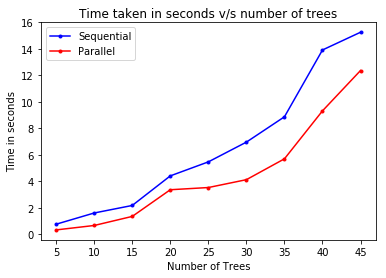

In [10]:
plt.plot(time_seq.keys(),time_seq.values(),marker='.',c='b',label='Sequential')
plt.plot(time_parallel.keys(),time_parallel.values(),marker = '.',c='r',label='Parallel')
plt.title('Time taken in seconds v/s number of trees')
plt.xlabel('Number of Trees')
plt.ylabel('Time in seconds')
plt.legend()

### 1 (d) Random Forest on Biased IRIS Dataset

In [11]:
def random_forest_iris(df,number=-1):
    lstcol = df.columns.tolist()
    lstcol.remove('Target')
    possible = []
    n_feature = int(np.sqrt(len(lstcol)))
    if number<=1:
        possible = []
        for i in combinations(lstcol,n_feature):
            possible.append(i)
        tree_avg_accuracy = []
        for i in possible:
            index = []
            for j in range(len(i)):
                index.append(i[j])
            index.append('Target')
            ndf = df[index]
            datas = np.array(ndf)
            train = datas[:105]
            test =  datas[105:]
            tree = tree_iris(train,4,1)
            tree_avg_accuracy.append(accurate(test,tree))
    else:
        tree_avg_accuracy = []
        for n in range(number//len(lstcol)+1):
            for i in combinations(lstcol,n_feature):
                possible.append(i)
            for i in possible:
                index = []
                for j in range(len(i)):
                    index.append(i[j])
                index.append('Target')
                ndf = df[index]
                datas = np.array(ndf)
                train = datas[:105]
                test = datas[105:]
                tree = tree_iris(train,4,1)
                tree_avg_accuracy.append(accurate(test,tree))
    return  np.array(tree_avg_accuracy).mean()

In [12]:
print('Random Forest Accuracy is ',random_forest_iris(df,20))
print('Decision Tree Accuracy is',accurate(np.array(df[105:]),tree_iris(np.array(df[:105]),4,1)))

Random Forest Accuracy is  62.96296296296296
Decision Tree Accuracy is 73.33333333333333


### 1 (e) 5-Fold Cross Validation and Performance

#### I am getting "Too Many Open Files", when the number of decision trees I need to grow exceeds 45. Therefore I am only comparing <=45
#### I am taking the tuple (1,5,10,20,30,45) for all testing purposes

* From my previous assignment -- Here is the Cross Validation and Nested Cross Validation
* I am implementing them without shuffling the dataset. Shuffling can also be done.
* Also, if the second argument to the function $dt$ decides if we're doing RF or DT.

In [13]:
##
## IF DECISION TREE, ,DT = 1, else anything apart from 1 for Random Forests
def kfold_cross_validation(df,dt=1):
    if dt==1:
        dataset = np.array(df)
        avg_acc = []
        for i in range(5):
            test = dataset[30*i:30*(i+1)]
            if 30*(i+1)+120<=150:
                train = dataset[30*(i+1):]
            else:
                train1 = dataset[0:30*(i+1)-30]
                train2 = dataset[30*(i+1):]
                train = np.append(train1,train2,axis=0)
            tree = tree_iris(train,4,0)
            avg_acc.append(accurate(test,tree))
        return np.array(avg_acc).mean()
    else:
        rf_avg = []
        dataset = df.copy()
        lstcol = df.columns.tolist()
        lstcol.remove('Target')
        n_feature = int(np.sqrt(len(lstcol)))
        dataset1= np.array(df)
        possible = []
        for i in combinations(lstcol,n_feature):
            possible.append(i)
        for i in possible:
            tree_avg_accuracy = []
            index = []
            for j in range(len(i)):
                index.append(i[j])
            index.append('Target')
            ndf = dataset[index]
            datas = np.array(ndf)
            for i in range(5):
                test = datas[30*i:30*(i+1)]
                if 30*(i+1)+120<=150:
                    train = datas[30*(i+1):]
                else:
                    train1 = datas[0:30*(i+1)-30]
                    train2 = datas[30*(i+1):]
                    train = np.append(train1,train2,axis=0)
                tree = tree_iris(train,4,1)
                tree_avg_accuracy.append(accurate(test,tree))
        rf_avg.append(np.array(tree_avg_accuracy).mean())
        print('The accuracy on Random Forests with K-Fold Cross Validation is',np.array(rf_avg).mean())

The average cross validation accuracy for Decision Tree is 89.33 %



In [14]:
kfold_cross_validation(df,0)
print('The Decision Tree accuracy is (5 Fold Cross Validation)',kfold_cross_validation(df))

The accuracy on Random Forests with K-Fold Cross Validation is 92.0
The Decision Tree accuracy is (5 Fold Cross Validation) 89.33333333333334


### Nested Cross Validation to find optimum number of trees in random forests
 I am reusing my code from Assignment 1

In [60]:
def nested_cross_validation(df,dt=1):
    if dt==1:
        print('here')
        dataset = np.array(df)
        for i in range(5):
            test = dataset[30*i:30*(i+1)]
            if 30*(i+1)+120<=150:
                train = dataset[30*(i+1):]
            else:
                train1 = dataset[0:30*(i+1)-30]
                train2 = dataset[30*(i+1):]
                train = np.append(train1,train2,axis=0)
            accuracy_validation = {}
            for depth in range(1,11):
                s = 0
                for j in range(4):
                    validation = train[30*j:30*(j+1)]
                    train_1 = train[30*(j+1):]
                    train_2 = train[0:30*(j+1)-30]
                    train_ = np.append(train_1,train_2,axis = 0)
                    tree = tree_iris(train_,depth,0)
                    s+=(accurate(validation,tree))
                accuracy_validation[depth] = s/4
            value = max(accuracy_validation, key = accuracy_validation.get)
            tree = tree_iris(train,value,0)
            print("Accuracy is,",accurate(test,tree), " for iteration",i+1, ". The depth of the optimal tree is ",value)
    else:
        dataset = df.copy()
        for i in range(5):
            test = dataset[30*i:30*(i+1)]
            if 30*(i+1)+120<=150:
                train = dataset[30*(i+1):]
            else:
                train1 = dataset[0:30*(i+1)-30]
                train2 = dataset[30*(i+1):]
                train = np.append(train1,train2,axis=0)
                valid_score = {}
                for number_of_trees in [5,10,20]:
                    print(number_of_trees)
                    s = 0
                    for j in range(4):
                        validation = train[30*j:30*(j+1)]
                        train_1 = train[30*(j+1):]
                        train_2 = train[0:30*(j+1)-30]
                        train_ = np.append(train_1,train_2,axis = 0)
                        s+=random_forest_kf(df,train_,validation,number_of_trees)
                    valid_score[number_of_trees] = s/4
                value = max(valid_score,key=valid_score.get)
                print('The # of trees is ',value,' and the score is ',random_forest_kf(df,train,test,value))

In [65]:
def random_forest_kf(df,train_,test_,number):
    lstcol = df.columns.tolist()
    lstcol.remove('Target')
    possible = []
    n_feature = int(np.sqrt(len(lstcol)))
    if number<=1:
        possible = []
        for i in combinations(lstcol,n_feature):
            possible.append(i)
        tree_avg_accuracy = []
        for i in possible:
            index = []
            for j in range(len(i)):
                index.append(i[j])
            index.append('Target')
            train = train_
            #datas = np.array(ndf)
            test = test_
            #train = np.array(train_)
            #test = np.array(test_)
            #train, test = train_test_split(datas, test_size = 0.3)
            tree = tree_iris(train,4,1)
            tree_avg_accuracy.append(accurate(test,tree))
        return np.array(tree_avg_accuracy).mean()
    else:
        tree_avg_accuracy = []
        #print(number//len(lstcol))
        for n in range(number//len(lstcol)+1):
            for i in combinations(lstcol,n_feature):
                possible.append(i)
            for i in possible:
                index = []
                for j in range(len(i)):
                    index.append(i[j])
                index.append('Target')
                print(train_)
                tree = tree_iris(train_,4,1)
                tree_avg_accuracy.append(accurate(test_,tree))
            #print(tree_avg_accuracy)
        return np.array(tree_avg_accuracy).mean()